# Overfitting and Regularization

## Imports

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.metrics import mean_squared_error
from sklearn import set_config

In [3]:
set_config(display='diagram')

## Settings

In [4]:
SEED = 42
RANGE = (-5, 5)
N_SAMPLES = 50
DEGREES = np.linspace(0, 15, 1 + 15, dtype=int)
ALPHAS = np.linspace(0, 0.5, 1 + 40)

## Part 1: Underfitting vs. overfitting

### Generate samples

Let's pick a target function $ f(x) = 2\cdot x + 10\cdot sin(x) $ and generate some noisy samples to learn from.

In [5]:
def target_function(x):
    return 2 * x + 10 * np.sin(x)

def generate_samples():
    """Generate noisy samples."""
    np.random.seed(SEED)
    x = np.random.uniform(*RANGE, size=N_SAMPLES)
    y = target_function(x) + np.random.normal(scale=4, size=N_SAMPLES)
    return x.reshape(-1, 1), y

X, y = generate_samples()

### Plot samples

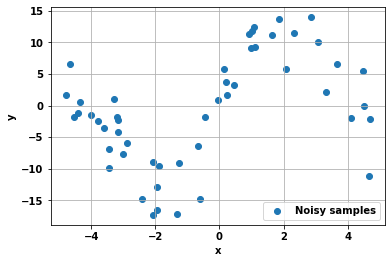

In [6]:
def plot_scatter(x, y, title=None, label='Noisy samples'):
    plt.scatter(x, y, label=label)
    plt.xlabel('x')
    plt.ylabel('y')
    plt.grid(True)
    plt.title(title)
    plt.legend(loc='lower right')

plot_scatter(X, y)

### Split

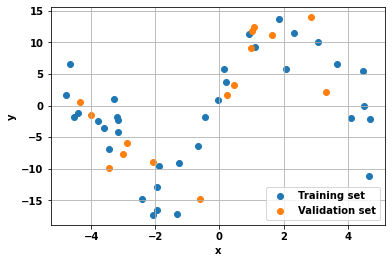

In [7]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.3, random_state=SEED)

plot_scatter(X_train, y_train, label='Training set')
plot_scatter(X_valid, y_valid, label='Validation set')

### Model

Let's try to approximate our target function $ f(x) = 2\cdot x + 10\cdot sin(x) $ with polynomials of different degree. 

A polynomial of degree $n$ has the form:
$ h(x) = w_0 + w_1\cdot x + w_2\cdot x^2 +\ldots + w_n\cdot x^n $.

$x^i$ values could easily be generated by `PolynomialFeatures`, while $w_i$ are the unknown paramaters to be estimated using `LinearRegression`.

In [8]:
PolynomialFeatures(degree=4).fit_transform(X=[
    [1],
    [3],
    [4],
])

array([[  1.,   1.,   1.,   1.,   1.],
       [  1.,   3.,   9.,  27.,  81.],
       [  1.,   4.,  16.,  64., 256.]])

In [9]:
def make_model(degree, alpha=0, penalty=None):
    # linear regression
    if alpha == 0:
        regressor = LinearRegression(fit_intercept=False)
    
    # lasso regression
    elif penalty == 'L1':
        regressor = Lasso(fit_intercept=False, alpha=alpha, random_state=SEED, max_iter=50000)        
    
    # ridge regression
    elif penalty == 'L2':
        regressor = Ridge(fit_intercept=False, alpha=alpha, random_state=SEED, max_iter=50000)        
    
    return Pipeline([
        ('pol', PolynomialFeatures(degree)),
        ('sca', StandardScaler()),
        ('reg', regressor)
    ])

display(make_model(2))
display(make_model(2, penalty='L1', alpha=0.1))
display(make_model(2, penalty='L2', alpha=0.1))

Pipeline(steps=[('pol', PolynomialFeatures()), ('sca', StandardScaler()),
                ('reg', LinearRegression(fit_intercept=False))])

Pipeline(steps=[('pol', PolynomialFeatures()), ('sca', StandardScaler()),
                ('reg',
                 Lasso(alpha=0.1, fit_intercept=False, max_iter=50000,
                       random_state=42))])

Pipeline(steps=[('pol', PolynomialFeatures()), ('sca', StandardScaler()),
                ('reg',
                 Ridge(alpha=0.1, fit_intercept=False, max_iter=50000,
                       random_state=42))])

### Fit

Let's fit a model and plot the hypothesis it learns:

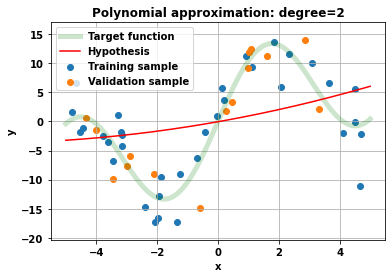

In [10]:
def plot_fit(model):
    degree = model['pol'].degree
    X_range = np.linspace(*RANGE, 1000).reshape(-1, 1)
    y_pred = model.predict(X_range)
    plot_scatter(X_train, y_train, label='Training sample')
    plot_scatter(X_valid, y_valid, label='Validation sample')
    plt.plot(X_range, target_function(X_range), c='green', alpha=0.2, lw=5, label='Target function')
    plt.plot(X_range, y_pred, c='red', label='Hypothesis')
    plt.ylim((min(y) - 3, max(y) + 3))
    plt.legend(loc='best')    
    plt.title(f'Polynomial approximation: degree={degree}')
    plt.show()

plot_fit(make_model(degree=2).fit(X_train, y_train))

### From underfitting to overfitting

We can investigate the shape of the fitted curve for different values of `degree`:

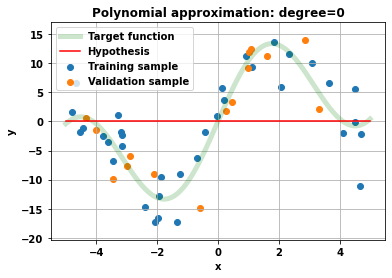

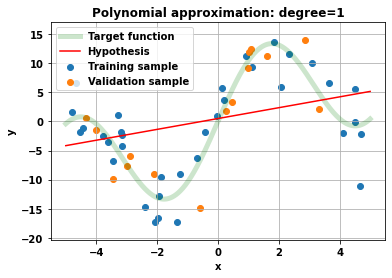

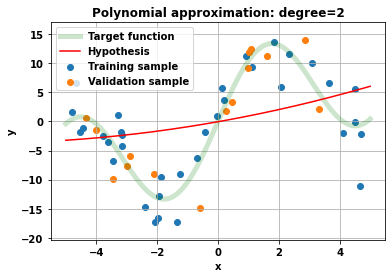

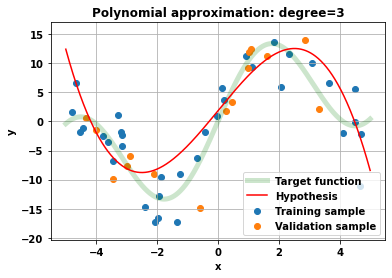

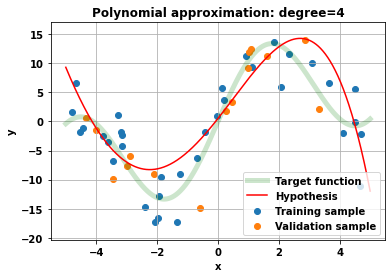

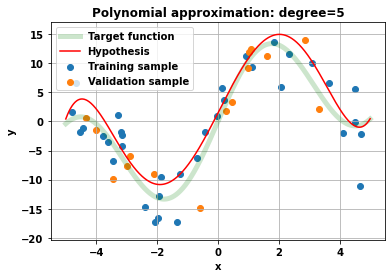

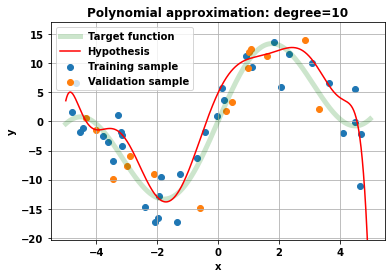

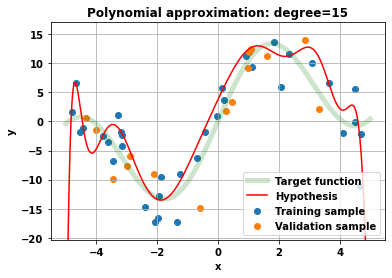

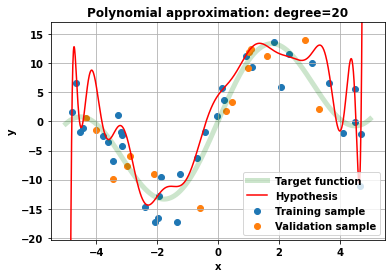

In [11]:
for degree in [0, 1, 2, 3, 4, 5, 10, 15, 20]:
    plot_fit(make_model(degree).fit(X_train, y_train))

### Fitting graph

In the next step we calculate the training and the validation error for each `degree` and plot them in a single graph. The resulting graph is called the fitting graph.

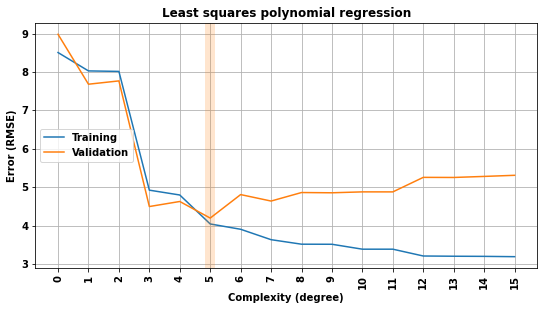

In [12]:
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

def plot_fitting_graph(x, metric_train, metric_valid, xlabel, ylabel, 
                       custom_metric=None, custom_label='', custom_scale='log', title='Fitting graph'):
    plt.figure(figsize=(9, 4.5))
    plt.plot(x, metric_train, label='Training')
    plt.plot(x, metric_valid, color='C1', label='Validation')
    plt.axvline(x[np.argmin(metric_valid)], color='C1', lw=10, alpha=0.2)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.grid(True)
    plt.xticks(x, rotation='vertical')
    plt.legend(loc='center left')        
    if custom_metric:
        plt.twinx()
        plt.yscale(custom_scale)
        plt.plot(x, custom_metric, alpha=0.2, lw=4, ls='dotted', color='black', label=custom_label) 
        plt.legend(loc='center right')         
    plt.show()
    
rmse_train, rmse_valid = [], []
for degree in DEGREES:
    reg = make_model(degree).fit(X_train, y_train)
    rmse_train.append(rmse(reg.predict(X_train), y_train))
    rmse_valid.append(rmse(reg.predict(X_valid), y_valid))
    
plot_fitting_graph(DEGREES, rmse_train, rmse_valid, xlabel='Complexity (degree)', ylabel='Error (RMSE)', 
                   title='Least squares polynomial regression')

### Sweet spot

What is the optimal `degree` to go with?

In [13]:
DEGREES[np.argmin(rmse_valid)]

5

### Cross-validation

Ideally, we would choose the the model parameters such that we have the best model performance. However, we want to make sure that we really have the best validation performance. When we do `train_test_split` we randomly split the data into two parts. What could happen is that we got lucky and split the data such that it favours the validation error. This is especially dangerous if we are dealing with small datasets. One way to check if that's the case is to run the experiment several times for different, random splits. However, there is an even more systematic way of doing this: [cross-validation](https://scikit-learn.org/stable/modules/cross_validation.html).

<img src="https://scikit-learn.org/stable/_images/grid_search_cross_validation.png" width=50% />

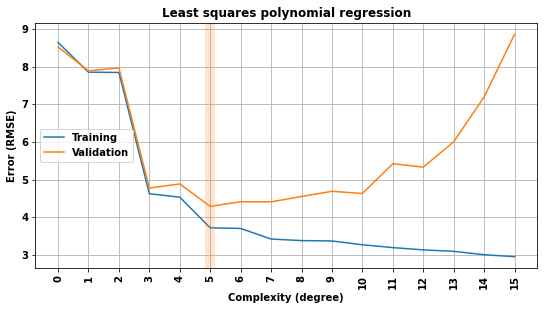

In [14]:
rmse_train, rmse_valid = [], []
for degree in DEGREES:
    results = cross_validate(make_model(degree), 
                             X, y, cv=5,
                             return_train_score=True,
                             scoring='neg_root_mean_squared_error')
    rmse_train.append(-np.mean(results['train_score']))
    rmse_valid.append(-np.mean(results['test_score']))
    
plot_fitting_graph(DEGREES, rmse_train, rmse_valid, xlabel='Complexity (degree)', ylabel='Error (RMSE)',
                   title='Least squares polynomial regression')

### Model coefficients

Let's inspect our regression model coefficients:

In [15]:
(make_model(degree=1).fit(X_train, y_train)['reg'].coef_,
 make_model(degree=2).fit(X_train, y_train)['reg'].coef_,
 make_model(degree=5).fit(X_train, y_train)['reg'].coef_,
 make_model(degree=10).fit(X_train, y_train)['reg'].coef_)

(array([0.        , 2.81292778]),
 array([0.        , 2.80049884, 0.45166501]),
 array([  0.        ,  30.87315584,   1.48752361, -54.60227825,
         -1.63699842,  26.62792933]),
 array([   0.        ,   33.63850705,  -41.86346242,  -70.48743112,
         278.98853452,   27.48125634, -656.36383501,   59.32988346,
         651.64795186,  -47.55728814, -233.48455138]))

Hmm... it looks like high degree polynomials are coming with much bigger regression coefficients. 

We are going to plot the mean absolute value of $w_i$ as a function of degree to reveal the relationship:

findfont: Font family ['DejaVu Sans Display'] not found. Falling back to DejaVu Sans.


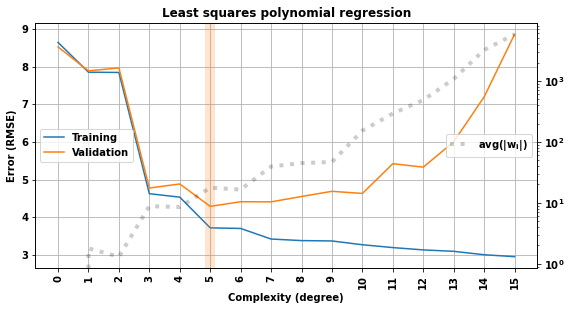

In [16]:
rmse_train, rmse_valid, avg_coef = [], [], []
for degree in DEGREES:
    results = cross_validate(make_model(degree),
                             X, y, cv=5,
                             return_train_score=True, return_estimator=True,
                             scoring='neg_root_mean_squared_error')
    rmse_train.append(-np.mean(results['train_score']))
    rmse_valid.append(-np.mean(results['test_score']))        
    avg_coef.append(        
        # average over CV folds
        np.mean([            
            # mean absolute value of weights
            np.mean(np.abs(model['reg'].coef_))
            for model in results['estimator']
        ]))
    
plot_fitting_graph(DEGREES, rmse_train, rmse_valid,
                   xlabel='Complexity (degree)', ylabel='Error (RMSE)',
                   custom_metric=avg_coef, custom_label='avg(|$w_i$|)',
                   title='Least squares polynomial regression')

### Summary

We observe the following:

1. **Underfitting** (degree < 5): The model is not able to fit the data properly. The fit is bad for both the training and the validation set.

2. **Fit is just right** (degree = 5): The model is able to capture the underlying data distribution. The fit is good for both the training and the validation set.

3. **Overfitting** (degree > 5): The model starts fitting the noise in the dataset. While the fit for the training data gets even better, the fit for the validation set gets worse.

4. As the order of polynomial increases, the linear model coefficients become more likely to take on **large values**.

## Part 2: Regularization

There are two major ways to build a machine learning model with the ability to generalize well on unseen data:
1. Train the simplest model possible for our purpose (according to Occam’s Razor).
2. Train a complex or more expressive model on the data and perform regularization.

Regularization is a method used to reduce the variance of a machine learning model. In other words, it is used to reduce overfitting. Regularization penalizes a model for being complex. For linear models, it means regularization forces model coefficients to be smaller in magnitude.

Let's pick a polynomial model of degree **15** (which tends to overfit strongly) and try to regularize it using **L1** and **L2** penalties.

### L1 - Lasso regression

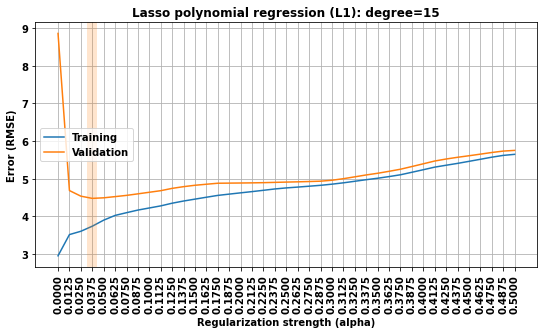

In [17]:
rmse_train, rmse_valid = [], []
for alpha in ALPHAS:    
    results = cross_validate(make_model(degree=15, penalty='L1', alpha=alpha), 
                             X, y, cv=5,
                             return_train_score=True,
                             scoring='neg_root_mean_squared_error')
    rmse_train.append(-np.mean(results['train_score']))
    rmse_valid.append(-np.mean(results['test_score']))
    
plot_fitting_graph(ALPHAS, rmse_train, rmse_valid,
                   xlabel='Regularization strength (alpha)', ylabel='Error (RMSE)',
                   title='Lasso polynomial regression (L1): degree=15')

### L2 - Ridge regression

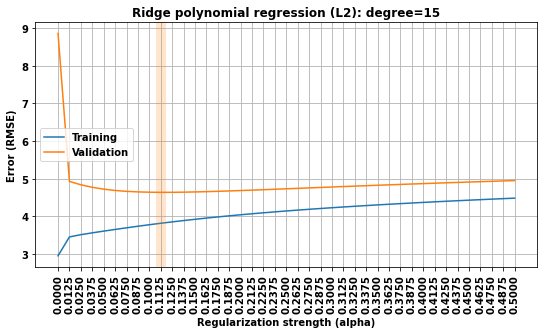

In [18]:
rmse_train, rmse_valid = [], []
for alpha in ALPHAS:    
    results = cross_validate(make_model(degree=15, penalty='L2', alpha=alpha), 
                             X, y, cv=5,
                             return_train_score=True,
                             scoring='neg_root_mean_squared_error')
    rmse_train.append(-np.mean(results['train_score']))
    rmse_valid.append(-np.mean(results['test_score']))
    
plot_fitting_graph(ALPHAS, rmse_train, rmse_valid, 
                   xlabel='Regularization strength (alpha)', ylabel='Error (RMSE)', 
                   title='Ridge polynomial regression (L2): degree=15')

### Summary

1. We can control the regularization strength by changing the hyperparameter `alpha`.
2. Regularized version of the model performs pretty well. Even in case the original original (unregularized) model is heavily overfitting due to excessive complexity.

## Part 3: Homework assignment (10 points)

### Excercise 1 - Magnitude (4 points)

As discussed earlier, regularization methods are expected to constraint the weights (model coefficients). 

Is it indeed happening? 

Please do a discovery on your own and find that out empirically (both for **L1** and **L2**). Let's use `degree=15` and `alpha` from `ALPHAS`.

#### L1

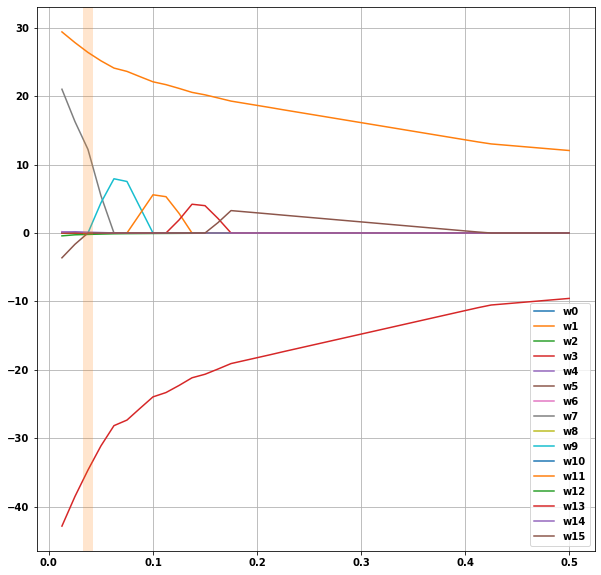

In [19]:
## your code
# Я использую данные с большим числом точек, чтобы результат был менее случайным и более объяснимым
N_SAMPLES = 1000
X, y = generate_samples()

coefs_L1 = []

for alpha in ALPHAS:    
    pipeline = make_model(degree=15, penalty='L1', alpha=alpha).fit(X, y)
    coefs_L1.append(pipeline.named_steps['reg'].coef_)

labels = ['w' + str(n) for n in np.arange(0, 16)]
plt.figure(figsize=(10, 10)) 
plt.plot(ALPHAS[1:], coefs_L1[1:]) # При альфе = 0 коэффициенты слишком большие и портят масштаб. 
# Но нулевая альфа означает отсутствие регуляризации и она нам интересна только как точка отсчета 
plt.legend(labels) # Я не очень понял почему coef_[0] у нас равен intercept, но тут они оба нулевые.
plt.grid()
plt.axvline(0.0375, color='C1', lw=10, alpha=0.2) # Оптимальная альфа из кросс-валидации
plt.show()

#### L2

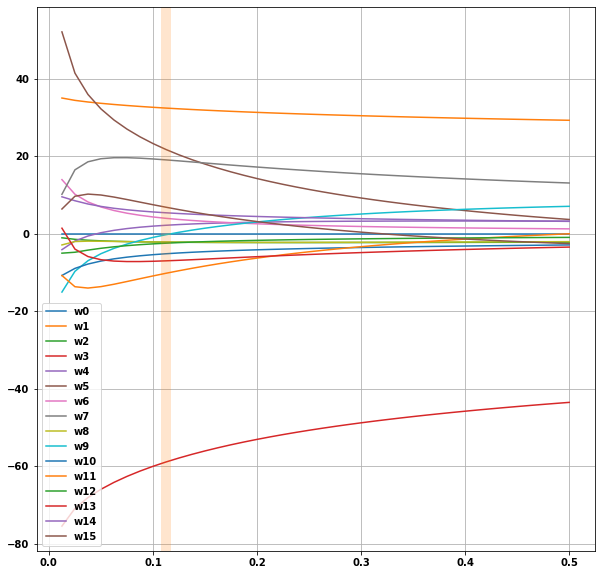

In [20]:
## your code
coefs_L2 = []

for alpha in ALPHAS:    
    pipeline = make_model(degree=15, penalty='L2', alpha=alpha).fit(X, y)
    coefs_L2.append(pipeline.named_steps['reg'].coef_)

labels = ['w' + str(n) for n in np.arange(0, 16)]
plt.figure(figsize=(10, 10)) 
plt.plot(ALPHAS[1:], coefs_L2[1:]) # При альфе = 0 коэффициенты слишком большие и портят масштаб. 
# Но нулевая альфа означает отсутствие регуляризации и она нам интересна только как точка отсчета 
plt.legend(labels) # Я не очень понял почему coef_[0] у нас равен intercept, но тут они оба нулевые.
plt.grid()
plt.axvline(0.1125, color='C1', lw=10, alpha=0.2) # Оптимальная альфа из кросс-валидации
plt.show()

#### Summary

**Уменьшает ли регуляризация веса модели?**

Да, сумма весов уменьшается в обоих случаях. Хотя иногда с увеличением альфы некоторые веса растут. Но, наша цель-то не уменьшить веса, а помешать модели переучиться, за счет ограничения роста весов. И по графикам выше, вроде бы и не определить
оптимальную для нашего примера альфу. Она зависит от природы данных, а не абсолютных размеров весов.

**Почему регуляризация работает именно так?**

L1-regularization, насколько я помню, исключает вклад признака в prediction, если его(вклада) размер по модулю меньше 1/2 альфа. *Что означают горки на графике?* Думаю, эти слагаемые (9, 11, 13 и 15 степени) имеют близкое суммарное влияние на точность. При этом 9 влияет на многие точки, но не очень сильно. А 15 сильнее, но на меньшее количество точек. Поэтому, он отбрасывается позже других.

L2-regularization просто сильнее штрафует большие веса. И если у признака остаются большие веса - он точно значим. С ростом альфы большие веса не станут больше, а вот маленькие - как повезет. И сильно задирать альфу нам тут незачем.

**Почему уменьшаются именно эти веса?**

У нас половина целевых значений отрицательные. Предсказывать их слагаемыми четной степени сложновато, т.к. они всегда больше нуля. Сильнее всего влияют слагаемые 1 и 3 степени. Дальше идут - 5 и 7. Что мы и видим на графиках.

### Excercise 2 - Sparsity (4 points)

Lasso can also be used for **feature selection** since L1 is [more likely to produce zero coefficients](https://explained.ai/regularization/).

Is it indeed happening? 

Please do a discovery on your own and find that out empirically (both for **L1** and **L2**). Let's use `degree=15` and `alpha` from `ALPHAS`.

#### L1

In [21]:
## your code
#По графикам выше все и так видно, посмотрим на числа
pd.set_option('display.max_columns', None)
coefs_L1_df = pd.DataFrame(coefs_L1, columns=labels, index=ALPHAS)
coefs_L1_df['count'] = coefs_L1_df[coefs_L1_df != 0].count(axis=1)
coefs_L1_df['abs_sum'] = coefs_L1_df.abs().sum(axis=1)
coefs_L1_df.T

,0.0000,0.0125,0.0250,0.0375,0.0500,0.0625,0.0750,0.0875,0.1000,0.1125,0.1250,0.1375,0.1500,0.1625,0.1750,0.1875,0.2000,0.2125,0.2250,0.2375,0.2500,0.2625,0.2750,0.2875,0.3000,0.3125,0.3250,0.3375,0.3500,0.3625,0.3750,0.3875,0.4000,0.4125,0.4250,0.4375,0.4500,0.4625,0.4750,0.4875,0.5000
w0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
w1,37.492301,29.382545,27.820133,26.385901,25.157407,24.099753,23.612589,22.845218,22.092915,21.675488,21.129575,20.548802,20.187116,19.735274,19.273385,18.960511,18.647186,18.334034,18.008852,17.694925,17.381244,17.068078,16.754317,16.440541,16.126754,15.813688,15.499883,15.186050,14.872169,14.558238,14.244245,13.930581,13.616681,13.303552,13.015516,12.854925,12.694362,12.534296,12.374069,12.213300,12.053252
w2,5.635878,-0.416173,-0.262227,-0.206341,-0.159185,-0.113260,-0.091774,-0.081348,-0.070787,-0.059806,-0.049203,-0.038647,-0.027346,-0.016718,-0.006161,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000
w3,-101.135536,-42.822594,-38.498812,-34.639489,-31.099261,-28.146962,-27.332853,-25.622779,-23.943874,-23.309734,-22.278087,-21.154281,-20.637464,-19.872729,-19.076733,-18.648268,-18.219364,-17.790676,-17.346930,-16.917272,-16.487922,-16.059217,-15.629767,-15.200298,-14.770815,-14.342235,-13.912730,-13.483190,-13.053589,-12.623928,-12.194187,-11.764857,-11.335235,-10.906575,-10.519248,-10.358676,-10.198131,-10.038043,-9.877807,-9.717071,-9.557000
w4,-81.960050,0.000000,0.000000,0.000000,0.000000,0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000
w5,130.871423,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000
w6,372.734753,0.194714,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000
w7,-10.475414,21.004956,16.289743,12.216980,5.443458,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000
w8,-830.383370,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000
w9,-319.954752,0.000000,0.000000,0.

#### L2

In [22]:
## your code
coefs_L2_df = pd.DataFrame(coefs_L2, columns=labels, index=ALPHAS)
coefs_L2_df['count'] = coefs_L2_df[coefs_L2_df != 0].count(axis=1)
coefs_L2_df['abs_sum'] = coefs_L2_df.abs().sum(axis=1)
coefs_L2_df.T

,0.0000,0.0125,0.0250,0.0375,0.0500,0.0625,0.0750,0.0875,0.1000,0.1125,0.1250,0.1375,0.1500,0.1625,0.1750,0.1875,0.2000,0.2125,0.2250,0.2375,0.2500,0.2625,0.2750,0.2875,0.3000,0.3125,0.3250,0.3375,0.3500,0.3625,0.3750,0.3875,0.4000,0.4125,0.4250,0.4375,0.4500,0.4625,0.4750,0.4875,0.5000
w0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
w1,37.492301,35.042804,34.441753,34.022773,33.679485,33.381480,33.115573,32.874510,32.653661,32.449768,32.260393,32.083631,31.917945,31.762069,31.614943,31.475669,31.343475,31.217695,31.097749,30.983127,30.873382,30.768117,30.666979,30.569652,30.475853,30.385330,30.297852,30.213212,30.131223,30.051713,29.974526,29.899520,29.826565,29.755540,29.686336,29.618852,29.552993,29.488674,29.425814,29.364339,29.304181
w2,5.635878,-1.010346,-1.404068,-1.637435,-1.793054,-1.903347,-1.984599,-2.046038,-2.093329,-2.130154,-2.159020,-2.181695,-2.199464,-2.213286,-2.223891,-2.231844,-2.237591,-2.241489,-2.243826,-2.244835,-2.244713,-2.243620,-2.241692,-2.239043,-2.235770,-2.231958,-2.227676,-2.222988,-2.217945,-2.212595,-2.206978,-2.201130,-2.195082,-2.188861,-2.182493,-2.175997,-2.169395,-2.162701,-2.155932,-2.149101,-2.142220
w3,-101.135536,-75.378341,-70.821392,-68.021023,-65.881100,-64.101449,-62.559311,-61.191419,-59.959849,-58.839388,-57.812017,-56.864172,-55.985254,-55.166744,-54.401649,-53.684130,-53.009249,-52.372782,-51.771084,-51.200988,-50.659717,-50.144829,-49.654162,-49.185793,-48.738007,-48.309265,-47.898183,-47.503515,-47.124130,-46.759004,-46.407205,-46.067882,-45.740258,-45.423621,-45.117318,-44.820748,-44.533357,-44.254634,-43.984106,-43.721335,-43.465916
w4,-81.960050,-4.068070,-1.835156,-0.550886,0.303372,0.913492,1.369503,1.721432,1.999576,2.223442,2.406198,2.557069,2.682719,2.788086,2.876910,2.952079,3.015855,3.070040,3.116085,3.155172,3.188274,3.216197,3.239619,3.259108,3.275150,3.288158,3.298486,3.306441,3.312289,3.316263,3.318564,3.319371,3.318841,3.317113,3.314309,3.310539,3.305900,3.300481,3.294358,3.287603,3.280277
w5,130.871423,52.100823,41.462543,35.968593,32.237730,29.374950,27.031855,25.039678,23.303934,21.765984,20.386550,19.137757,17.998921,16.954153,15.990901,15.099034,14.270219,13.497505,12.775020,12.097748,11.461370,10.862134,10.296762,9.762368,9.256405,8.776604,8.320945,7.887615,7.474986,7.081588,6.706091,6.347288,6.004080,5.675464,5.360524,5.058421,4.768382,4.489697,4.221713,3.963824,3.715471
w6,372.734753,13.988976,10.223070,8.233799,6.943122,6.025805,5.336585,4.798311,4.365585,4.009756,3.711775,3.458452,3.240355,3.050547,2.883812,2.736151,2.604441,2.486211,2.379477,2.282629,2.194344,2.113528,2.039266,1.970787,1.907438,1.848659,1.793971,1.742960,1.695265,1.650571,1.608604,1.569121,1.531906,1.496769,1.463541,1.432071,1.402221,1.373870,1.346908,1.321235,1.296761
w7,-10.475414,10.214373,16.523494,18.594492,19.386662,19.648861,19.655196,19.527602,19.327254,19.087393,18.827093,18.557710,18.286163,18.016714,17.751978,17.493531,17.242278,16.998687,16.762938,16.535024,16.314814,16.102101,15.896629,15.698117,15.506268,15.320782,15.141363,14.967722,14.799577,14.636661,14.478716,14.325499,14.176778,14.032335,13.891963,13.755468,13.622664,13.493381,13.367453,13.244728,13.125060
w8,-830.383370,-2.851193,-1.976436,-1.875194,-1.900548,-1.950061,-1.999640,-2.043167,-2.079556,-2.109217,-2.132954,-2.151607,-2.165936,-2.176596,-2.184141,-2.189033,-2.191660,-2.192347,-2.191367,-2.188952,-2.185298,-2.180571,-2.174915,-2.168453,-2.161291,-2.153522,-2.145224,-2.136469,-2.127317,-2.117822,-2.108031,-2.097986,-2.087724,-2.077277,-2.066674,-2.055941,-2.045101,-2.034175,-2.023180,-2.012133,-2.001048
w9,-319.954752,-15.006445,-9.661137,-6.927759,-5.107530,-3.736148,-2.631412,-1.705

#### Summary

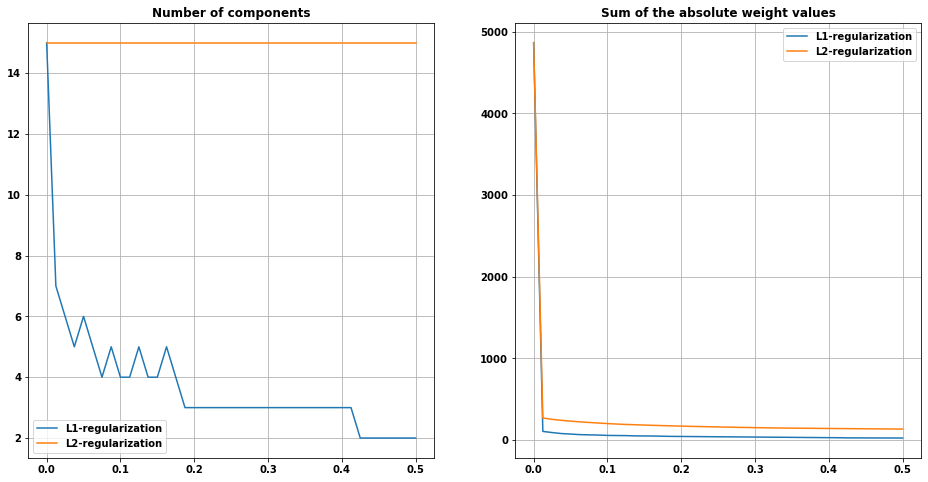

In [23]:
# Визуализируем отбор признаков
f, (ax1, ax2) = plt.subplots(1, 2,figsize=(16,8)) 
ax1.plot(coefs_L1_df['count'], label ='L1-regularization')
ax1.plot(coefs_L2_df['count'], label ='L2-regularization')
ax1.set_title('Number of components')
ax1.legend()
ax1.grid()
ax2.plot(coefs_L1_df['abs_sum'], label ='L1-regularization')
ax2.plot(coefs_L2_df['abs_sum'], label ='L2-regularization')
ax2.set_title('Sum of the absolute weight values')
ax2.legend()
ax2.grid()
plt.show()

**Работает ли L1-regularization для отбора признаков?**

Да, она отбрасывает признаки с наименьшим вкладом. Но, при слишком большой альфе модель будет переучена и потеряет часть точности. Думаю, лучше альфу занизить, чем точно подогнать под выборку.

### Excercise 3 - Scaling (2 points)

As a general rule, it is recommended to scale input features before fitting a regularized model so that the features/inputs take values in similar ranges. One common way of doing so is to standardize the inputs and that is exactly what our pipeline  second step (`StandardScaler`) is responsible for. 

Why is scaling important? What are the underlying reasons?

In [24]:
# Сначала проверим полезен ли StandardScaler в нашей задаче

# Еще раз сгенерируем данные
N_SAMPLES = 1000
X, y = generate_samples()
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.3, random_state=SEED)

In [25]:
def make_alternative_model(degree, alpha=0, penalty=None):        
    # linear regression
    if alpha == 0:
        regressor = LinearRegression(fit_intercept=False)
    
    # lasso regression
    elif penalty == 'L1':
        regressor = Lasso(fit_intercept=False, alpha=alpha, random_state=SEED, max_iter=50000)        
    
    # ridge regression
    elif penalty == 'L2':
        regressor = Ridge(fit_intercept=False, alpha=alpha, random_state=SEED, max_iter=50000)        
    
    return Pipeline([
        ('pol', PolynomialFeatures(degree)),
        #('sca', StandardScaler()),
        ('reg', regressor)
    ])
# Сначала проверим модель без регуляризаии
pipeline = make_model(degree=15).fit(X_train, y_train)
print('rmse with StandardScaler', rmse(pipeline.predict(X_valid), y_valid))

pipeline = make_alternative_model(degree=15).fit(X_train, y_train)
print('rmse without StandardScaler', rmse(pipeline.predict(X_valid), y_valid))

# Теперь с L2-регуляризаией
pipeline = make_model(degree=15, penalty='L2', alpha=0.1125).fit(X_train, y_train)
print('rmse L2-model with StandardScaler', rmse(pipeline.predict(X_valid), y_valid))

pipeline = make_alternative_model(degree=15, penalty='L2', alpha=0.1125).fit(X_train, y_train)
print('rmse L2-model without StandardScaler', rmse(pipeline.predict(X_valid), y_valid))

rmse with StandardScaler 3.8623790066799555
rmse without StandardScaler 3.86935583719603
rmse L2-model with StandardScaler 3.8517337961997447
rmse L2-model without StandardScaler 3.8675937004967125


D:\Anaconda\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.75181e-22): result may not be accurate.
  overwrite_a=True).T


**Есть ли в нашей задаче полза от использования StandardScaler?**

Скорее всего нет. При другом SEED в примере выше она пропадает. Учитывая как формируются наши данные, ее и не должно быть.

**В чем суть скейлинга?**

Масштабирование и стандартизация значений признаков. StandardScaler проводит т.н. Z-score normalization. 

Преобразовывая признаки так:  $ z = \frac{x-μ}{σ} $ 

**Когда он полезен?** 

Когда абсолютные значения признаков или их дисперсии сильно различаются. Линейная регрессия в таком случае даст большие веса признакам с большими абсолютными значениями, а не большим вкладом в уменьшение ошибки. Многие ML алгоритмы чувствительны к таким вещам. Хотя, я подозреваю, в реализациях таких алгоритмов скейлинг может уже быть вшит.

**Когда бесполезен/вреден??**

Не всем алгоритмам нужна нормализация. Деревьям, например - нет. Конкретно Z-score normalization искажает относительные расстояния между объектами и иногда может и навредить.